#### Загрузим необходимые библиотеки

In [20]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from statsmodels.stats.proportion import proportions_ztest

#### Загрузим данные и посмотрим на них

In [2]:
path = 'https://stepik.org/media/attachments/lesson/396012/hw_aa.csv'

In [3]:
df = pd.read_csv(path, sep = ';', index_col = 0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127018 entries, 1 to 127018
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


In [8]:
df.groupby('experimentVariant').purchase.count()

experimentVariant
0    63102
1    63916
Name: purchase, dtype: int64

Группы примерно равны по размерам

In [9]:
df.groupby(['experimentVariant', 'version']).agg({'purchase' : 'count'}).rename(columns={'purchase': 'count'})

count
experimentVariant version        
0                 v2.8.0    41283
                  v2.9.0    11921
                  v3.7.4.0   4204
                  v3.8.0.0   5694
1                 v2.8.0    41552
                  v2.9.0    12033
                  v3.7.4.0   4221
                  v3.8.0.0   6110

Разделение в разрезе версий между группами практически одинаковое

#### Симулируем "синтетические" АА тесты

Расчитаем долю ложноположительных оценок (FPR) на уровне альфа 0.05.

Расчитаем АА с синтетическими тестами (в данном случае используется ttest, так как среднее значений (0 и 1) колонки purchase ничто иное как конверсия):

  0%|          | 0/1000 [00:00<?, ?it/s]

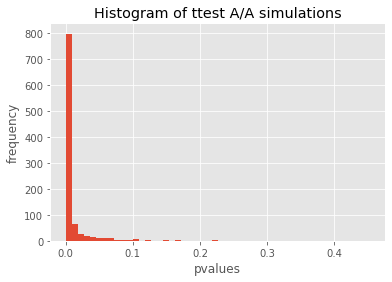

0.926

In [12]:
simulations = 1000 # количество симуляций
n_s = 1000 #размер выборки
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Доля ложноположительных оценок выше заданого уровня 0.05.

Основные причины кроются в сломанном сплит-алгоритме. Причины необходимо искать на стороне, где реализован скрипт и его запуск. Частые кейсы:

* Долгое ожидание ответа сервера по присвоению id эксперимента и сплита
* Приоритет той или иной группе
* Не на всех страницах или кейсах реализован сплит-алгоритм
* Банально «сломан» рандом (например, неправильно посчитан остаток от деления по сумме хеша)

Посмотрим конверсию по группам в разрезер версий:

In [13]:
df.groupby(['experimentVariant', 'version']).agg({'purchase' : 'mean'}).rename(columns={'purchase': 'conversion'}).unstack()

conversion                              
version               v2.8.0    v2.9.0  v3.7.4.0  v3.8.0.0
experimentVariant                                         
0                   0.000993  0.074658  0.059943  0.057604
1                   0.045606  0.071304  0.063018  0.062848

Конверия в группе 0 v2.8.0 значительно отличается, похоже проблема именно в этой версии.

Проверим каждую версию по отдельности при помощи ttest:

**Нулевая гипотеза (H0)** между средними значениями в обоих группах нет различия
**Альтернативная гипотеза (H1)** средние значения в обоих группах не равны
Отвергать нулевую гипотезу будем при уровне p-value < 0.05

In [15]:
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v2.8.0'").purchase,
                df.query("experimentVariant == 1 and version == 'v2.8.0'").purchase, equal_var=False)

Ttest_indResult(statistic=-43.097051598551076, pvalue=0.0)

In [16]:
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v2.9.0'").purchase,
                df.query("experimentVariant == 1 and version == 'v2.9.0'").purchase, equal_var=False)

Ttest_indResult(statistic=0.997860971925487, pvalue=0.31835686930247525)

In [17]:
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v3.7.4.0'").purchase, df.query("experimentVariant == 1 and version == 'v3.7.4.0'").purchase, equal_var = False)

Ttest_indResult(statistic=-0.5875202960070302, pvalue=0.5568700784122844)

In [18]:
stats.ttest_ind(df.query("experimentVariant == 0 and version == 'v3.8.0.0'").purchase, df.query("experimentVariant == 1 and version == 'v3.8.0.0'").purchase, equal_var = False)

Ttest_indResult(statistic=-1.1973368830477649, pvalue=0.2311993431794881)

В случае с версией v.2.8.0 мы отвергаем нулевую гипотезу, что значит, что средние в группах стат. значимо отличаются.

Снова расчитаем АА тест исключив версию v.2.8.0

  0%|          | 0/1000 [00:00<?, ?it/s]

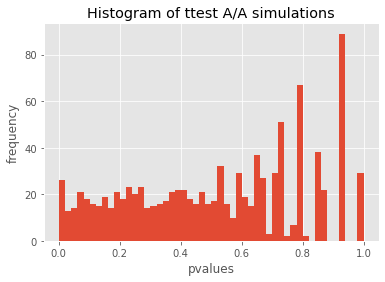

0.044

In [19]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 0 and version != 'v2.8.0'").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 0 and version != 'v2.8.0'").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

В данном случае доля ложноположительных оценок ниже установленного уровня альфа(0,05), следовательно поломка сплит системы выявлена - неправильно расплитованы данные для версии v2.8.0